In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *

import seaborn as sns
import scipy


In [4]:
# pairs = pd.read_pickle("/data/patrick_res/sessions/SA/pairs_at_least_3blocks_7sess.pickle")
pairs = pd.read_pickle("/data/patrick_res/sessions/SA/pairs_at_least_3blocks_10sess_more_sess.pickle")


In [5]:
# PRE_INTERVAL = 1000
# POST_INTERVAL = 1000
# INTERVAL_SIZE = 100
# SMOOTH = 1
# EVENT = "StimOnset"

PRE_INTERVAL = 0
POST_INTERVAL = 600
INTERVAL_SIZE = 50
NUM_BINS_SMOOTH = 1
EVENT = "decision_warped"

# EVENT = "FeedbackOnset"  # event in behavior to align on
# PRE_INTERVAL = 1300   # time in ms before event
# POST_INTERVAL = 1500  # time in ms after event
# INTERVAL_SIZE = 100  # size of interval in ms

OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# # path to a dataframe of sessions to analyze

In [6]:
pref_accs = []
pref_shuffle_accs = []
not_pref_accs = []
not_pref_shuffle_accs = []
for (feat1, feat2) in pairs.pair.values:
    pair_str = f"{feat1}_{feat2}"
    # not_pref_str = "_chosen_not_pref" if chosen_not_preferred else ""
    name = f"preferred_beliefs_{EVENT}_pair_{pair_str}"
    # name = f"preferred_beliefs_more_sess_{EVENT}_pair_{pair_str}"

    pref_acc = np.load(os.path.join(OUTPUT_DIR, f"{name}_test_accs.npy"))
    pref_accs.append(pref_acc)
    for i in range(1, 10): 
        shuffle_acc = np.load(os.path.join(OUTPUT_DIR, f"{name}_shuffle_{i}_test_accs.npy"))
        pref_shuffle_accs.append(shuffle_acc)
    
    name = f"preferred_beliefs_{EVENT}_pair_{pair_str}_chosen_not_pref"
    # name = f"preferred_beliefs_more_sess_{EVENT}_pair_{pair_str}_chosen_not_pref"

    not_pref_acc = np.load(os.path.join(OUTPUT_DIR, f"{name}_test_accs.npy"))
    not_pref_accs.append(not_pref_acc)
    for i in range(10): 
        shuffle_acc = np.load(os.path.join(OUTPUT_DIR, f"{name}_shuffle_{i}_test_accs.npy"))
        not_pref_shuffle_accs.append(shuffle_acc)
pref_accs = np.hstack(pref_accs)
pref_shuffle_accs = np.hstack(pref_shuffle_accs)
not_pref_accs = np.hstack(not_pref_accs)
not_pref_shuffle_accs = np.hstack(not_pref_shuffle_accs)

In [7]:
def assess_significance_bootstrap(acc, shuffled_acc, alpha=0.05 / 12, n=1000):
    rng = np.random.default_rng()
    num_t, num_accs = acc.shape
    mean_diffs = np.mean(acc, axis=1) - np.mean(shuffled_acc, axis=1)

    shuff_mean_diffs = np.empty((num_t, n))
    combined = np.hstack((acc, shuffled_acc))
    for i in np.arange(n):
        rng.shuffle(combined, axis=1)
        shuff_mean_diffs[:, i] = np.mean(combined[:, num_accs:], axis=1) - np.mean(combined[:, :num_accs], axis=1)
    quantiles = np.quantile(shuff_mean_diffs, axis=1, q=(1 - alpha))
    return mean_diffs > quantiles



In [8]:
times = np.arange(-(PRE_INTERVAL / 1000), POST_INTERVAL / 1000, INTERVAL_SIZE / 1000) + INTERVAL_SIZE / 1000
sig_times = assess_significance_bootstrap(pref_accs, pref_shuffle_accs)
sig_times = times[sig_times]

sig_not_pref_times = assess_significance_bootstrap(not_pref_accs, not_pref_shuffle_accs)
sig_not_pref_times = times[sig_not_pref_times]

Text(0.5, 1.0, 'Preferred beliefs')

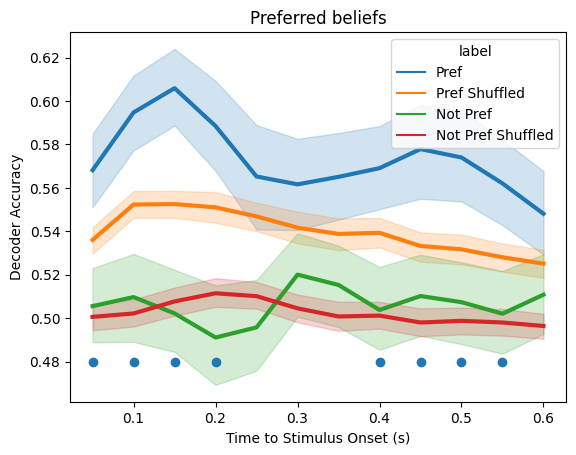

In [11]:
fig, ax = plt.subplots()
visualization_utils.plot_accs_seaborn(
    [pref_accs, pref_shuffle_accs, not_pref_accs, not_pref_shuffle_accs], 
    ["Pref", "Pref Shuffled", "Not Pref", "Not Pref Shuffled"], 
    pre_interval=PRE_INTERVAL,
    interval_size=50,
    ax=ax)
# visualization_utils.plot_accs_seaborn(
#     [pref_accs, pref_shuffle_accs], 
#     ["Pref", "Pref Shuffled"], 
#     pre_interval=PRE_INTERVAL,
#     interval_size=100,
#     ax=ax)
ax.scatter(sig_times, np.ones(len(sig_times)) * 0.48, color="tab:blue")
ax.scatter(sig_not_pref_times, np.ones(len(sig_not_pref_times)) * 0.47, color="tab:green")
ax.set_xlabel("Time to Stimulus Onset (s)")
ax.set_ylabel("Decoder Accuracy")
# ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_title("")

# fig, ax = plt.subplots()
# visualization_utils.plot_accs_seaborn(
#     [pref_accs, pref_shuffle_accs], 
#     ["Pref", "Pref Shuffled"], 
#     pre_interval=PRE_INTERVAL,
#     interval_size=50,
#     ax=ax)
# ax.scatter(sig_times, np.ones(len(sig_times)) * 0.48, color="tab:blue")
# # ax.scatter(sig_not_pref_times, np.ones(len(sig_not_pref_times)) * 0.47, color="tab:green")


In [6]:
pref_shuffle_accs.shape

(20, 720)

In [24]:
np.mean(pref_accs, axis=1)

array([0.54168403, 0.56793403, 0.57319444, 0.57796875, 0.57895833,
       0.56961806, 0.58390625, 0.59456597, 0.63454861, 0.66673611,
       0.65888889, 0.64647569, 0.64083333, 0.63407986, 0.62776042,
       0.62064236, 0.61958333, 0.63072917, 0.62574653, 0.57190972])

### Scrap

In [16]:
PAIRS_PATH = "/data/patrick_res/sessions/SA/pairs_at_least_3blocks_10sess_more_sess.pickle"
pairs = pd.read_pickle(PAIRS_PATH)

In [18]:
pairs

,pair,sessions,num_sessions,dim_type
0,"[CIRCLE, SQUARE]","[20180615, 20180709, 20180802, 20180803, 20180...",14,within dim
4,"[CIRCLE, GREEN]","[20180802, 20180806, 20180808, 20180813, 20180...",11,across dim
6,"[CIRCLE, YELLOW]","[20180802, 20180810, 20180813, 20180821, 20180...",13,across dim
9,"[CIRCLE, RIPPLE]","[20180615, 20180802, 20180803, 20180810, 20180...",10,across dim
13,"[SQUARE, CYAN]","[20180801, 20180802, 20180803, 20180820, 20180...",11,across dim
14,"[SQUARE, GREEN]","[20180802, 20180806, 20180808, 20180830, 20180...",10,across dim
15,"[SQUARE, MAGENTA]","[20180801, 20180802, 20180803, 20180806, 20180...",11,across dim
16,"[SQUARE, YELLOW]","[20180801, 20180802, 20180810, 20180820, 20180...",12,across dim
17,"[SQUARE, ESCHER]","[20180803, 20180808, 20180810, 20180820, 20180...",10,across dim
39,"[CYAN, MAGENTA]","[20180705, 20180801, 20180802, 20180803, 20180...",11,within dim
